# Introduction to Machine Learning: PCAM challenge

## Setup

In order to be ready to jump in to the project, you need access to the data for the challenge and should load needed packages (and install them if colab or your computer don't have them installed.)

In [1]:
# if you want to work in colab, set this to True to access your google drive for the data
work_in_colab = False

if work_in_colab:
    # set up google drive to access the data
    from google.colab import drive
    drive.mount('/content/drive')
    # define a directory prefix to where you are storing your project
    data_prefix = 'drive/MyDrive/Work/IntroToML/'
else:
    data_prefix = ''

### imports and installs

In [2]:
#!pip install torchvision
#!pip install h5py
import torch
import torchvision
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

# uncomment these 2 lines if you want to do use this automated hyperparameter optimization tool
!pip install optuna
import optuna


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


## The data

This dataset can be troublesome to automatically download depending on Google Drive's daily download quota. It is also not the smallest (> 7GB), so we have prepared a subset that you can download. I recommend creating a project folder (on your machine or colab) and save the data in that directory under `data`.

In [3]:
# Load the data splits
# this dataset requires the h5py package
pcam_data_train = torchvision.datasets.PCAM(
    root=data_prefix+'data',
    split='train',
    download=False,
    transform=torchvision.transforms.ToTensor() # otherwise the data is a PIL image
)
pcam_data_val = torchvision.datasets.PCAM(
    root=data_prefix+'data',
    split='val',
    download=False,
    transform=torchvision.transforms.ToTensor()
)
pcam_data_test = torchvision.datasets.PCAM(
    root=data_prefix+'data',
    split='test',
    download=False,
    transform=torchvision.transforms.ToTensor()
)

### First time: getting to know the data

Datasets are often structured a little differently. At the beginning of a project, it helps to familiarize oneself with its structure.

In [4]:
# printing the dataset will give you information on how many samples it has, where it is stored and what transformations are applied
pcam_data_train

Dataset PCAM
    Number of datapoints: 26215
    Root location: data
    StandardTransform
Transform: ToTensor()

In [6]:
# data from pytorch is often a tuple of (data, label)

# have a look at the first sample
print("data of first sample is stored as ", type(pcam_data_train[0]), " with length ", len(pcam_data_train[0]))
print("the two elements of the tuple are data and label: ", [type(x) for x in pcam_data_train[0]])

data of first sample is stored as  <class 'tuple'>  with length  2
the two elements of the tuple are data and label:  [<class 'torch.Tensor'>, <class 'int'>]


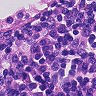

In [7]:
# if you want to visualize the data, you can convert it back to a PIL image

torchvision.transforms.ToPILImage()(pcam_data_train[0][0])

In [8]:
# what is the size of these images?

print(pcam_data_train[0][0].shape)
# this image has 3 channels (RGB) and is 96x96 pixels

# the label is binary and indicates the presence of metastatic tissue
print(pcam_data_train[0][1])

torch.Size([3, 96, 96])
0


In [9]:
# the label is binary and indicates the presence of metastatic tissue

# how many cancer samples are in the data?

all_labels = [x[1] for x in pcam_data_train]
print(sum(all_labels), ' out of ', len(all_labels), ' samples are from cancer')

13114  out of  26215  samples are from cancer


## What could you be doing?

### 1. build CNN classifier and optimize hyperparameters.
Hyperparameters could be optimized manually, or by using optimization packages like optuna.

### 2. Train and evaluate your classifier.
Here you could look into fitting measures of performance evaluation and their relevance for decision making.

### 3. Can you improve model generalization via data augmentation?
The tumor areas in the images are centered, which could lead to bad performance with new data that is not. Play around with some image transformations and see if this improves your test performance.

### 4. Explainable AI: Which parts of the image does the model use to make a decision? 
You could play around with models like RISE () to understand your model's decision making. This is a more advanced task. Feel free to ask for help if you are interested in this.

# My challenge

## 1. build and train a classifier

### How about a baseline first?

In [6]:
# implement a simple regression model as a baseline for binary classification

# the model should take an image as input and output a single value between 0 and 1
# the value should be interpreted as the probability of the image being cancerous
import numpy as np
from sklearn.linear_model import LinearRegression
# transform image data into np array
X = np.array([x[0].numpy().flatten() for i, x in enumerate(pcam_data_train) if i % 100 == 0])
y = np.array([x[1] for i, x in enumerate(pcam_data_train) if i % 100 == 0])
print(len(X))

263


In [7]:
# fit the linear model
reg = LinearRegression().fit(X, y)

In [8]:
# now evaluate on validation set
X = np.array([x[0].numpy().flatten() for i, x in enumerate(pcam_data_val) if i % 100 == 0])
y = np.array([x[1] for i, x in enumerate(pcam_data_val) if i % 100 == 0])
y_pred_regression = reg.predict(X)

In [ ]:
# let's look at the predictions and define some performance metrics. we can have this all put out by a function that we can later also use on our model's predictions

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, precision_recall_curve
def evaluate_predictions(y_true, y_pred):
    # first create a figure with 4 subplots
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    # add spacing between the subplots
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    # make text smaller
    plt.rcParams.update({'font.size': 8})
    # find the optimal threshold for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("optimal threshold: ", optimal_threshold)
    # plot the ROC curve
    axs[0, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[0, 0].plot([0, 1], [0, 1], 'k--')
    axs[0, 0].set_xlim([0.0, 1.0])
    axs[0, 0].set_ylim([0.0, 1.05])
    axs[0, 0].set_xlabel('False Positive Rate')
    axs[0, 0].set_ylabel('True Positive Rate')
    axs[0, 0].set_title('Receiver operating characteristic')
    axs[0, 0].legend(loc="lower right")
    # plot the confusion matrix
    y_pred_binary = y_pred > optimal_threshold
    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()
    axs[0, 1].imshow(cm, cmap=plt.cm.Blues)
    # add numbers to the confusion matrix
    for i in range(2):
        for j in range(2):
            axs[0, 1].text(j, i, format(cm[i, j], 'd'),
                           horizontalalignment="center",
                           color="white" if cm[i, j] > cm.max() / 2. else "black")
    axs[0, 1].set_xticks([0, 1])
    axs[0, 1].set_yticks([0, 1])
    axs[0, 1].set_xlabel("Predicted label")
    axs[0, 1].set_ylabel("True label")
    axs[0, 1].set_title("Confusion matrix")
    # plot the distribution of the predictions
    axs[1, 0].hist(y_pred[y_true == 0], bins=20, alpha=0.5, label='no cancer')
    axs[1, 0].hist(y_pred[y_true == 1], bins=20, alpha=0.5, label='cancer')
    axs[1, 0].set_xlabel('prediction')
    axs[1, 0].set_ylabel('count')
    axs[1, 0].set_title('Distribution of predictions')
    axs[1, 0].legend()
    # precision recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    axs[1, 1].plot(recall, precision)
    axs[1, 1].set_xlabel('recall')
    axs[1, 1].set_ylabel('precision')
    axs[1, 1].set_title('Precision recall curve')
    # type I error: false positive rate (fp / (fp + tn)))
    # plot it in the next row as the fpr against the threshold
    axs[2, 0].plot(thresholds, fpr)
    axs[2, 0].set_xlabel('threshold')
    axs[2, 0].set_ylabel('false positive rate')
    axs[2, 0].set_title('Type I error')
    # type II error: false negative rate (fn / (fn + tp))
    # plot it as the fnr against the threshold
    axs[2, 1].plot(thresholds, 1 - tpr)
    axs[2, 1].set_xlabel('threshold')
    axs[2, 1].set_ylabel('false negative rate')
    axs[2, 1].set_title('Type II error')
    # plot the false discovery rate (fdr) against the threshold (fdr = fp / (fp + tp))
    axs[3, 0].plot(thresholds, fp / (fp + tp))
    axs[3, 0].set_xlabel('threshold')
    axs[3, 0].set_ylabel('false discovery rate')
    axs[3, 0].set_title('False discovery rate')
    # F1 score
    axs[3, 1].plot(thresholds, [f1_score(y_true, y_pred > t) for t in thresholds])
    axs[3, 1].set_xlabel('threshold')
    axs[3, 1].set_ylabel('F1 score')
    axs[3, 1].set_title('F1 score')
    plt.show()

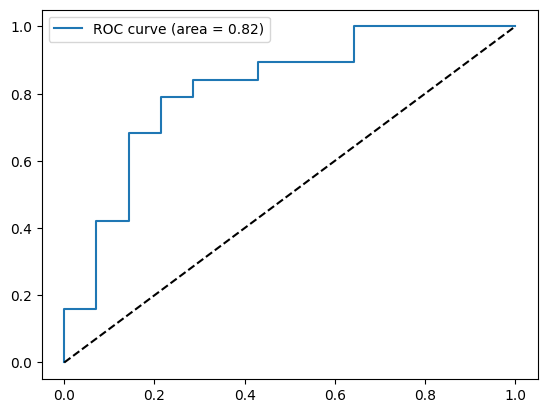

In [11]:
# plot test ROC curve
from sklearn.metrics import confusion_matrix, roc_curve, auc
fpr, tpr, _ = roc_curve(y, y_pred_regression)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

### Now build your model and optimize hyperparameters

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# build a simple CNN with some flexibility for hyperparam optimization
class Net(nn.Module):
    def __init__(self,
                 kernel_size=4,
                 num_filters=32,
                 num_layers_conv=3,
                 num_layers_fc=2,
                 n_hidden_fc=64,
                 dropout=0.1,
                 image_size=96,
                 stride=2):
        super(Net, self).__init__()
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.num_layers_conv = num_layers_conv
        self.num_layers_fc = num_layers_fc
        self.dropout = dropout

        # build the encoder
        conv_size = image_size
        self.main = nn.ModuleList()
        for i in range(num_layers_conv):
            if i == 0:
                in_channels = 3
                out_channels = num_filters
            else:
                in_channels = num_filters
                out_channels = num_filters
            self.main.append(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride))
            self.main.append(nn.ReLU())
            #self.main.append(nn.MaxPool2d(pool_size, 1))
            #conv_size = int((conv_size - kernel_size)/stride) + 1 - pool_size + 1
            conv_size = int((conv_size - kernel_size)/stride) + 1
        self.main.append(nn.Flatten()) # transition from 2d tp 1d
        for i in range(num_layers_fc):
            if i == 0:
                self.main.append(nn.Linear(num_filters * conv_size * conv_size, n_hidden_fc))
            else:
                self.main.append(nn.Linear(n_hidden_fc, n_hidden_fc))
            self.main.append(nn.ReLU())
            self.main.append(nn.Dropout(dropout))
        self.main.append(nn.Linear(n_hidden_fc, 1))
        self.main.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.main:
            x = layer(x)
        return x.flatten()

In [18]:
# do hyperparameter optimization based on a 10% subset of the training data
# I will use optuna here for this, but you can also use your own hyperparameter optimization tool or do it yourself by playing around

step = 100

train_indices = list(range(0, len(pcam_data_train), step))
pcam_train_subset = torch.utils.data.Subset(pcam_data_train, train_indices)

val_indices = list(range(0, len(pcam_data_val), step))
pcam_val_subset = torch.utils.data.Subset(pcam_data_val, val_indices)

# define an objective to optimize
def objective(trial):
    # sample hyperparameters
    kernel_size = trial.suggest_int('kernel_size', 2, 4)
    num_filters = trial.suggest_categorical('num_filters',[8, 16, 32, 64])
    num_layers_conv = trial.suggest_int('num_layers_conv', 1, 4)
    num_layers_fc = trial.suggest_int('num_layers_fc', 1, 4)
    n_hidden_fc = trial.suggest_categorical('n_hidden_fc', [16, 32, 64, 128, 256])
    dropout = trial.suggest_float('dropout', 0., 0.5, step=0.1)
    stride = trial.suggest_int('stride', 1, 4)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])
    # build the model
    model = Net(kernel_size=kernel_size,
                num_filters=num_filters,
                num_layers_conv=num_layers_conv,
                num_layers_fc=num_layers_fc,
                n_hidden_fc=n_hidden_fc,
                dropout=dropout,
                stride=stride)
    model = model.to(device)
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define the loss function
    criterion = nn.BCELoss()
    # train the model
    train_loader = torch.utils.data.DataLoader(pcam_train_subset, batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(5):
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    # evaluate the model
    model.eval()
    val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            break
    return loss

In [19]:
study = optuna.create_study()
study.optimize(objective, n_trials=20)

study.best_params

[I 2023-04-19 09:34:14,161] A new study created in memory with name: no-name-dc55fded-4a9c-4b6e-844b-b314515a2bb8
[I 2023-04-19 09:34:15,931] Trial 0 finished with value: 0.7077401280403137 and parameters: {'kernel_size': 4, 'num_filters': 8, 'num_layers_conv': 2, 'num_layers_fc': 1, 'n_hidden_fc': 32, 'dropout': 0.30000000000000004, 'stride': 4, 'lr': 0.008533400454199801, 'batch_size': 256}. Best is trial 0 with value: 0.7077401280403137.
[I 2023-04-19 09:34:17,951] Trial 1 finished with value: 0.689586877822876 and parameters: {'kernel_size': 2, 'num_filters': 32, 'num_layers_conv': 4, 'num_layers_fc': 2, 'n_hidden_fc': 64, 'dropout': 0.1, 'stride': 3, 'lr': 0.000802658600060212, 'batch_size': 128}. Best is trial 1 with value: 0.689586877822876.
[I 2023-04-19 09:34:47,593] Trial 2 finished with value: 0.676378071308136 and parameters: {'kernel_size': 3, 'num_filters': 32, 'num_layers_conv': 3, 'num_layers_fc': 2, 'n_hidden_fc': 256, 'dropout': 0.5, 'stride': 1, 'lr': 0.0016996326247

KeyboardInterrupt: 

### How many datapoints are actually needed?

Now that you found some good parameters, train the model with different numbers of data points and evaluate the performances on the validation set. Do we need all the data to perform as well as we can?

In [ ]:
test_loader = torch.utils.data.DataLoader(pcam_data_test, batch_size=32, shuffle=True)

In [160]:
hyper_dict = study.best_params
steps = [1000, 500, 100, 50, 10, 1]

def train(hyper_dict, step, n_epochs):
    print('training with step =', step)
    kernel_size = hyper_dict['kernel_size']
    num_filters = hyper_dict['num_filters']
    num_layers_conv = hyper_dict['num_layers_conv']
    num_layers_fc = hyper_dict['num_layers_fc']
    n_hidden_fc = hyper_dict['n_hidden_fc']
    dropout = hyper_dict['dropout']
    stride = hyper_dict['stride']
    lr = hyper_dict['lr']
    batch_size = hyper_dict['batch_size']
    # loaders
    train_indices = list(range(0, len(pcam_data_train), step))
    pcam_train_subset = torch.utils.data.Subset(pcam_data_train, train_indices)
    train_loader = torch.utils.data.DataLoader(pcam_train_subset, batch_size=batch_size, shuffle=True)
    val_indices = list(range(0, len(pcam_data_val), step))
    pcam_val_subset = torch.utils.data.Subset(pcam_data_val, val_indices)
    val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
    # build model
    model = Net(kernel_size=kernel_size,
                num_filters=num_filters,
                num_layers_conv=num_layers_conv,
                num_layers_fc=num_layers_fc,
                n_hidden_fc=n_hidden_fc,
                dropout=dropout,
                stride=stride)
    model = model.to(device)
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define the loss function
    criterion = nn.BCELoss()
    # train the model
    for epoch in range(n_epochs):
        model.train()
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # evaluate the model
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    return len(train_indices), test_loss

In [161]:
test_losses = []
train_sample_sizes = []
for step in steps:
    step_samples, step_loss = train(hyper_dict, step, n_epochs=10)
    test_losses.append(step_loss)
    train_sample_sizes.append(step_samples)

training with step = 1000
training with step = 500
training with step = 100
training with step = 50
training with step = 10


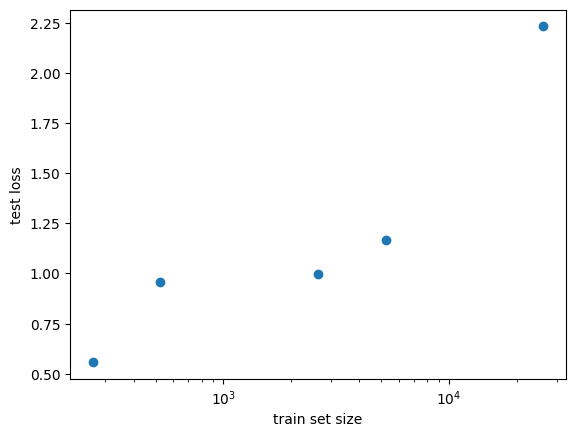

In [165]:
# plot test losses against train set size
plt.scatter(train_sample_sizes, test_losses)
plt.xscale('log')
plt.xlabel('train set size')
plt.ylabel('test loss')
plt.show()

## Evaluation

What are fitting metrics for performance evaluation? An easy start is the ROC curve and AUC. Since this is about medical data and making decisions about whether cancer is present or not, type I and II errors are also of great interest.

### train a model

In [144]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define an objective to optimize
def train(hyper_dict, step, n_epochs):
    print('training with step =', step)
    kernel_size = hyper_dict['kernel_size']
    num_filters = hyper_dict['num_filters']
    num_layers_conv = hyper_dict['num_layers_conv']
    num_layers_fc = hyper_dict['num_layers_fc']
    n_hidden_fc = hyper_dict['n_hidden_fc']
    dropout = hyper_dict['dropout']
    stride = hyper_dict['stride']
    lr = hyper_dict['lr']
    batch_size = hyper_dict['batch_size']
    # loaders
    train_indices = list(range(0, len(pcam_data_train), step))
    pcam_train_subset = torch.utils.data.Subset(pcam_data_train, train_indices)
    train_loader = torch.utils.data.DataLoader(pcam_train_subset, batch_size=batch_size, shuffle=True)
    val_indices = list(range(0, len(pcam_data_val), step))
    pcam_val_subset = torch.utils.data.Subset(pcam_data_val, val_indices)
    val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
    # build model
    model = Net(kernel_size=kernel_size,
                num_filters=num_filters,
                num_layers_conv=num_layers_conv,
                num_layers_fc=num_layers_fc,
                n_hidden_fc=n_hidden_fc,
                dropout=dropout,
                stride=stride)
    model = model.to(device)
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define the loss function
    criterion = nn.BCELoss()
    # train the model
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_losses.append(0)
        val_losses.append(0)
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            train_losses[-1] += loss.item()
            optimizer.step()
        train_losses[-1] /= len(train_loader)
        # evaluate the model
        model.eval()
        val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device).float()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                val_losses[-1] += loss.item()
            val_losses[-1] /= len(val_loader)
        print('   epoch', epoch, ', train loss ', train_losses[-1], ', val loss ', val_losses[-1])
    return model, train_losses, val_losses

In [ ]:
# first train the model on the whole data
model, train_losses, val_losses = train(study.best_params, step=1, n_epochs=2)

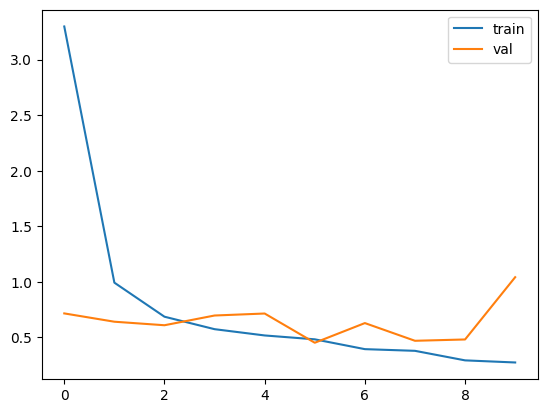

In [146]:
# plot the losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

### evaluation

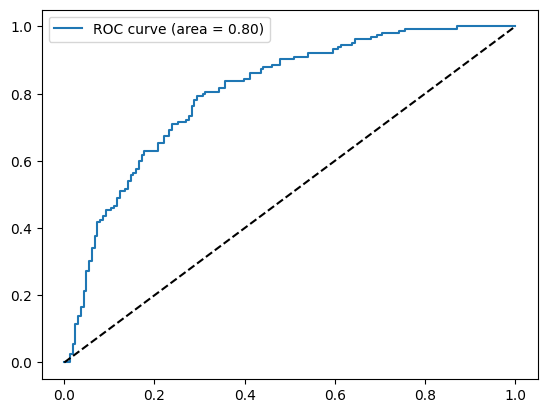

In [190]:
# plot test ROC curve
from sklearn.metrics import roc_curve, auc
model.eval()
test_loader = torch.utils.data.DataLoader(pcam_data_test, batch_size=32, shuffle=True)
y_true = []
y_preds = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device).float()
        y_pred = model(x)
        y_true.extend(y.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())
fpr, tpr, _ = roc_curve(y_true, y_preds)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

In [ ]:
# Type I and Type II errors

## XAI: understanding how the model makes decisions

### RISE

In [168]:
!pip install scikit-image
import numpy as np
import torch
import torch.nn as nn
from skimage.transform import resize
from tqdm import tqdm


class RISE(nn.Module):
    def __init__(self, model, input_size, gpu_batch=100):
        super(RISE, self).__init__()
        self.model = model
        self.input_size = input_size
        self.gpu_batch = gpu_batch

    def generate_masks(self, N, s, p1, savepath='masks.npy'):
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size

        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')

        self.masks = np.empty((N, *self.input_size))

        for i in tqdm(range(N), desc='Generating filters'):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            self.masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                         anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        self.masks = self.masks.reshape(-1, 1, *self.input_size)
        np.save(savepath, self.masks)
        self.masks = torch.from_numpy(self.masks).float()
        self.masks = self.masks.cuda()
        self.N = N
        self.p1 = p1

    def load_masks(self, filepath):
        self.masks = np.load(filepath)
        self.masks = torch.from_numpy(self.masks).float().cuda()
        self.N = self.masks.shape[0]

    def forward(self, x):
        N = self.N
        _, _, H, W = x.size()
        # Apply array of filters to the image
        stack = torch.mul(self.masks, x.data)

        # p = nn.Softmax(dim=1)(model(stack)) processed in batches
        p = []
        for i in range(0, N, self.gpu_batch):
            p.append(self.model(stack[i:min(i + self.gpu_batch, N)]))
        p = torch.cat(p).unsqueeze(1)
        # Number of classes
        CL = p.size(1)
        sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(N, H * W))
        sal = sal.view((CL, H, W))
        sal = sal / N / self.p1
        return sal

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 19.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 16.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 19.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.4/219.4 kB 4.7 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [171]:
input_size = (96,96)
gpu_batch = 32
explainer = RISE(model, input_size)
# Generate masks for RISE
maskspath = 'masks.npy'
explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)

Generating filters: 100%|██████████| 6000/6000 [00:03<00:00, 1942.60it/s]


AssertionError: Torch not compiled with CUDA enabled

In [ ]:
def example(img, label):
    print(img.shape)
    saliency = explainer(img.unsqueeze(0).to(device)).cpu().numpy()
    #p = model(img.to(device)).cpu().detach().numpy()
    #p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = torch.topk(model(img.unsqueeze(0).to(device)), k=1)
    #print(p, c)
    #p, c = p[0], c[0]
    
    plt.figure(figsize=(6, 3))
    print("Cancer: "+str(label))
    plt.subplot(1,2,1)
    plt.axis('off')
    #plt.title('{:.2f}% {}'.format(100*p[k], get_class_name(c[k])))
    #tensor_imshow(img[0])
    plt.imshow(torchvision.transforms.ToPILImage()(img))#.show()

    plt.subplot(1,2,2)
    plt.axis('off')
    #plt.title(get_class_name(c[k]))
    #tensor_imshow(img[0])
    plt.imshow(torchvision.transforms.ToPILImage()(img))#.show()
    sal = saliency[c]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()

for i in range(10):
  example(pcam_data_train[i][0], pcam_data_train[i][1])

### Improving generalization

Does the model get better on the test performance if we train with augmented data?
- rotation
- cropping (and shifting)

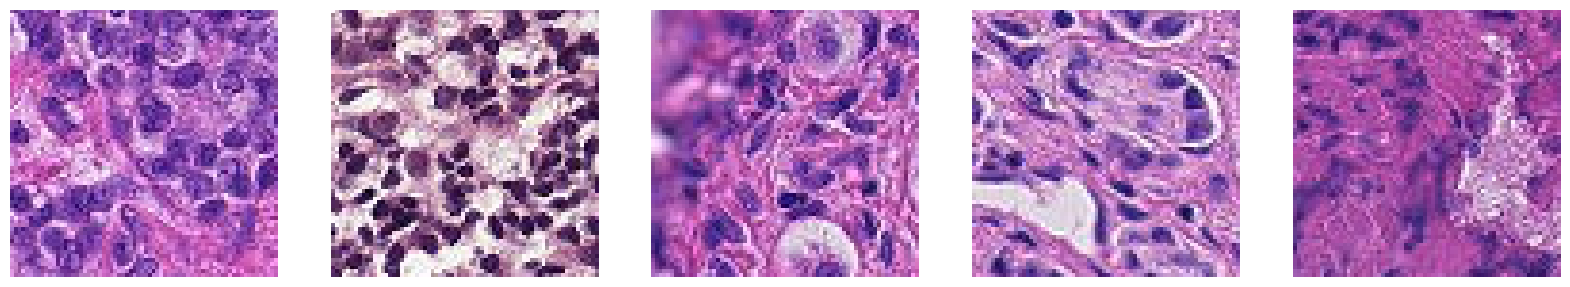

In [201]:
# first visualize the applied augmentation to see if it is enough

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(70, padding=0),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor()
])
pcam_data_val_aug = torchvision.datasets.PCAM(
    root='./data',
    split='val',
    download=False,
    transform=transform
)

# visualize the augmented data
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
for i in range(5):
    ax[i].axis('off')
    ax[i].imshow(torchvision.transforms.ToPILImage()(pcam_data_val_aug[i][0]))
plt.show()

In [202]:
# now apply to train data
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(70, padding=0),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.ToTensor()
])
pcam_data_train = torchvision.datasets.PCAM(
    root='./data',
    split='train',
    download=False,
    transform=transform
)

In [203]:
# now train a model with rotated, cropped and shifted images

hyper_dict = {'kernel_size': 2,
 'num_filters': 45,
 'num_layers_conv': 1,
 'num_layers_fc': 1,
 'n_hidden_fc': 28,
 'dropout': 0.0,
 'stride': 2,
 'lr': 0.002175681303000298,
 'batch_size': 32}

def train(hyper_dict, step, n_epochs):
    print('training with step =', step)
    kernel_size = hyper_dict['kernel_size']
    num_filters = hyper_dict['num_filters']
    num_layers_conv = hyper_dict['num_layers_conv']
    num_layers_fc = hyper_dict['num_layers_fc']
    n_hidden_fc = hyper_dict['n_hidden_fc']
    dropout = hyper_dict['dropout']
    stride = hyper_dict['stride']
    lr = hyper_dict['lr']
    batch_size = hyper_dict['batch_size']
    # loaders
    train_indices = list(range(0, len(pcam_data_train), step))
    pcam_train_subset = torch.utils.data.Subset(pcam_data_train, train_indices)
    train_loader = torch.utils.data.DataLoader(pcam_train_subset, batch_size=batch_size, shuffle=True)
    val_indices = list(range(0, len(pcam_data_val), step))
    pcam_val_subset = torch.utils.data.Subset(pcam_data_val, val_indices)
    val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
    # build model
    model = Net(kernel_size=kernel_size,
                num_filters=num_filters,
                num_layers_conv=num_layers_conv,
                num_layers_fc=num_layers_fc,
                n_hidden_fc=n_hidden_fc,
                dropout=dropout,
                stride=stride)
    model = model.to(device)
    # define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # define the loss function
    criterion = nn.BCELoss()
    # train the model
    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        model.train()
        train_losses.append(0)
        val_losses.append(0)
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device).float()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            train_losses[-1] += loss.item()
            optimizer.step()
        train_losses[-1] /= len(train_loader)
        # evaluate the model
        model.eval()
        val_loader = torch.utils.data.DataLoader(pcam_val_subset, batch_size=batch_size, shuffle=True)
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.to(device).float()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                val_losses[-1] += loss.item()
            val_losses[-1] /= len(val_loader)
    return model, train_losses, val_losses

model, train_losses, val_losses = train(hyper_dict, step=100, n_epochs=2)

training with step = 100


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x55125 and 103680x28)